In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# **Initializing objects:**

In [2]:
True & False

False

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


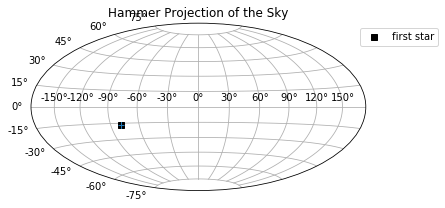

In [4]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [5]:
1/24*3

0.125

In [6]:
scanSirio.scan(gaia, sirio, ti=t_init, tf=t_end)
#print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
#print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
#print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)

Starting scan with time from 0 to 365 days
time for constraints t: 9.583333333333332 is 0.001153707504272461
time for t: 9.583333333333332   : 0.0011246204376220703
time for constraints t: 41.541666666666664 is 0.0009496212005615234
time for t: 41.541666666666664   : 0.0010266304016113281
time for constraints t: 89.41666666666666 is 0.0009686946868896484
time for t: 89.41666666666666   : 0.0009725093841552734
time for constraints t: 100.66666666666666 is 0.000978231430053711
time for t: 100.66666666666666   : 0.0009610652923583984
time for constraints t: 149.54166666666666 is 0.0009815692901611328
time for t: 149.54166666666666   : 0.001024007797241211
time for constraints t: 174.75 is 0.000989675521850586
time for t: 174.75   : 0.0009882450103759766
time for constraints t: 214.95833333333331 is 0.0010044574737548828
time for t: 214.95833333333331   : 0.0010833740234375
time for constraints t: 267.375 is 0.0010137557983398438
time for t: 267.375   : 0.001026153564453125
time for constr

In [7]:
angle = np.radians(270)
angle % (2*np.pi)

4.71238898038469

# **Plots:**

In [8]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [9]:


def vector_error(t):
                u_lmn_unit = source.unit_topocentric_function(sat, t)
                vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
                vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
                return vector_error_xyz



In [10]:
print(scanSirio.obs_times)

[9.586563909073732, 41.55002559983842, 89.43814050895162, 100.68603093351706, 149.55670111235565, 174.78619267030336, 214.9716169022323, 267.40321154547445, 267.6532162165947, 293.8983901208061, 294.1483973638092, 352.5781383953659]


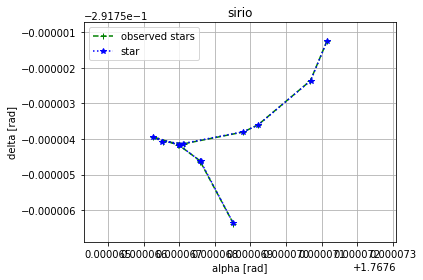

12

In [11]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha, delta, radius = ft.vector_to_polar(satellite.func_x_axis_lmn(t))
    alphas_obs.append(alpha % (2 * np.pi))
    deltas_obs.append(delta)
    # radius_obs.append(radius)
    # source.set_time(t)
    # star_alphas.append(source.alpha)
    # star_deltas.append(source.delta)
    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append(alpha2)
    star_deltas.append(delta2)
    # star_deltas.append(source.radius)

    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    v_error = vector_error(t)

    vectorz1 = xaxis + np.radians(0.5) * zaxis
    vectorz2 = xaxis - np.radians(0.5) * zaxis

    z_alpha_1, z_delta_1, _ = ft.vector_to_polar(vectorz1)
    z_alpha_2, z_delta_2, _ = ft.vector_to_polar(vectorz2)

    z_alphas.append([z_alpha_1, z_alpha_2])
    z_deltas.append([z_delta_1, z_delta_2])
    
    vectorz1 = xaxis + v_error[2]*zaxis

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(green_alpha)
    green_deltas.append(green_delta)

# For each couple of ([alpha1,alpha2],[delta1,delta2])
for alpha_delta in zip(z_alphas, z_deltas):
    # plt.plot(alpha_delta[0], alpha_delta[1], 'yo-')
    pass
# plt.plot(alphas_obs, deltas_obs, 'ro--', label='observations')  # plot observation as re dots
    
plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [rad]'), plt.ylabel('delta [rad]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

In [12]:
for t in scanSirio.obs_times:
    eta_real, zeta_real = observed_field_angles(sirio, gaia.func_attitude(t),
                                               gaia, t)
    eta_obs, zeta_obs = 

SyntaxError: invalid syntax (<ipython-input-12-222fe8723aae>, line 4)

# **2- Combine with solver:**

In [33]:
my_sirio = Calc_source(scanSirio.obs_times, source=sirio) 

print('real:', my_sirio.s_params)
my_sirio.set_params(my_sirio.s_params + my_sirio.s_params*1e-10)
print('noised:', my_sirio.s_params)
Solver = Agis(gaia, [my_sirio], [sirio], updating='source')

real: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]
noised: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]


In [34]:
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.02 / 1
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 10
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

my_sirio = Calc_source('sirio', scanSirio.obs_times, s, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio], updating='source')

In [35]:
Solver.iterate(100)

***** Iteration: 1 *****
Error after iteration: 0.000153008809647701
***** Iteration: 2 *****
Error after iteration: 2.6697917625371652e-06
***** Iteration: 3 *****
Error after iteration: 2.4715996918589736e-06
***** Iteration: 4 *****
Error after iteration: 6.627631397558842e-07
***** Iteration: 5 *****
Error after iteration: 1.538428406768837e-07
***** Iteration: 6 *****
Error after iteration: 3.513471578902248e-08
***** Iteration: 7 *****
Error after iteration: 8.028742982613239e-09
***** Iteration: 8 *****
Error after iteration: 1.8426196307927732e-09
***** Iteration: 9 *****
Error after iteration: 4.238035985423906e-10
***** Iteration: 10 *****
Error after iteration: 9.756594433171414e-11
***** Iteration: 11 *****
Error after iteration: 2.246564918753008e-11
***** Iteration: 12 *****
Error after iteration: 5.168580492981453e-12
***** Iteration: 13 *****
Error after iteration: 1.1892770289785512e-12
***** Iteration: 14 *****
Error after iteration: 2.7401377984819833e-13
***** Itera

In [ ]:
optimize.brentq(f=eta_error, a=t, b=t+time_step, args=(